# Duffing Oscillator

---

This notebook implements the [Duffing oscillator](http://www.scholarpedia.org/article/Duffing_oscillator) in Julia. Similer to the [Lorenz Attractor](https://github.com/JuliaLang/ODE.jl/blob/master/examples/Lorenz_Attractor.ipynb), Duffing oscillator is also a chaotic attractor system.

![Duffing Oscillator](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Forced_Duffing_equation_Poincaré_section.png/638px-Forced_Duffing_equation_Poincaré_section.png)

Image courtesy of [WikiMedia](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Forced_Duffing_equation_Poincaré_section.png/638px-Forced_Duffing_equation_Poincaré_section.png)

The Duffing oscillator is formally described by a second-order differential equation. In the following equations, $t$ represents time, $\delta$ is the dumping constant, $\gamma$ is the forcing amplitude, $\omega$ is the angular velocity, and the $x$ is the function of position. When $\beta > 0$ the duffing oscillator can be interpreted as a forced oscillator. The force can be written as $F = - \beta x - \alpha x^3$. When $\alpha > 0$, this spring is called a hardening spring, and, when $\alpha<0$, it is called a softening spring although this interpretation is valid only for small x (Thompson and Stewart, 2002).

![Parameters](http://www.scholarpedia.org/w/images/5/51/Duffing-RestoringForce.gif)

Image courtesy of [Scholarpedia](http://www.scholarpedia.org/w/images/5/51/Duffing-RestoringForce.gif)

$$ \frac{d^2x}{dt^2} + \delta \frac{dx}{dt} + \beta x + \alpha x^3 = \gamma cos ( \omega t ) $$

---

In order to use the ODE.jl package to solve this problem. We need to rewrite this second-oder differential equation into a system of first-order differential equations as following.

$$ \begin{cases} 
  v'(t) = \gamma cos ( \omega t ) - ( \delta v + \beta x + \alpha x^3 )
  \\\\ 
  x'(t) = v(t)
\end{cases} $$

In [1]:
using ODE;
using PyPlot;

In [2]:
function duffing_oscillator(t, y)
    (v, x) = y

    v_prime = γ * cos(ω * t) - (δ * v + β * x + α * x^3)
    x_prime = v

    [v_prime, x_prime]
end;

<b>Set parameters values</b>

In [3]:
α = 1;
β = -1;
δ = 0.2;
γ = 0.3;
ω = 1;

<b>Set initial values and time interval. <i>Attention</i>: The initial values have to correspond to what the previous
function returns.</b>

In [4]:
start = [1.0, pi - 1e-3];
time = [0:0.0125:200;];
tspan_warming_up = [0:0.0125:1;];

<b>Warm up the JIT with a small time span</b>

In [5]:
ODE.ode78(duffing_oscillator, start, tspan_warming_up);
ODE.ode23s(duffing_oscillator, start, tspan_warming_up);

<b>Using different solvers and different tolerances</b> (The comparison will be in the following notebook)

ode78 is an adaptive explicit [Runge-Kutta](https://en.wikipedia.org/wiki/Runge–Kutta_methods) solver, and ode23s (better for stiff problem, but slower than explicit) is a implicit [Runge-Kutta](https://en.wikipedia.org/wiki/Runge–Kutta_methods) solver.

The lower the tolerance values are the smaller the step size the solver will use. Therefore, small tol (tolerance) will give us a more accurate result.

Since the ode23s runs slowly, it is better to run with a relatively higher tolerance.

In [6]:
@time (t1, y1) = ode78(duffing_oscillator, start, time, points=:specified, reltol = 1e-16, abstol = 1e-16);
@time (t2, y2) = ode78(duffing_oscillator, start, time, points=:specified, reltol = 5e-17, abstol = 5e-17);
@time (t3, y3) = ode23s(duffing_oscillator, start, time, points=:specified, reltol = 1e-9, abstol = 1e-9);
@time (t4, y4) = ode23s(duffing_oscillator, start, time, points=:specified, reltol = 5e-10, abstol = 5e-10);

  0.124077 seconds (1.73 M allocations: 35.325 MB, 7.58% gc time)
  0.084589 seconds (1.88 M allocations: 38.138 MB, 7.83% gc time)
  8.917763 seconds (23.34 M allocations: 2.057 GB, 3.80% gc time)
 11.179722 seconds (27.26 M allocations: 2.416 GB, 4.41% gc time)


<b>Exctract velocity $x'(t)$ and position $x(t)$ arrays</b>

In [7]:
velocity1 = map(f -> f[1], y1);
position1 = map(f -> f[2], y1);
velocity2 = map(f -> f[1], y2);
position2 = map(f -> f[2], y2);
velocity3 = map(f -> f[1], y3);
position3 = map(f -> f[2], y3);
velocity4 = map(f -> f[1], y4);
position4 = map(f -> f[2], y4);

<b>Plot a [limit cycle](https://en.wikipedia.org/wiki/Limit_cycle) graph of this system</b>

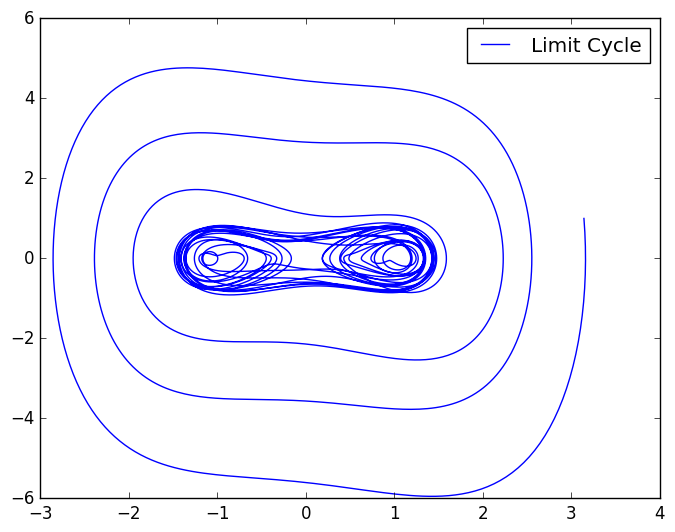

In [8]:
PyPlot.plot(position2, velocity2, label="Limit Cycle");
PyPlot.legend();

<b>Comparison between ode78 with different tolerances</b>

---

The results of ode78 with lower tolerance (reltol = abstol = 5e-17) and ode78 (reltol = abstol = 1e-16) don't have big differences.

Therefore, the results of ode78 converge.

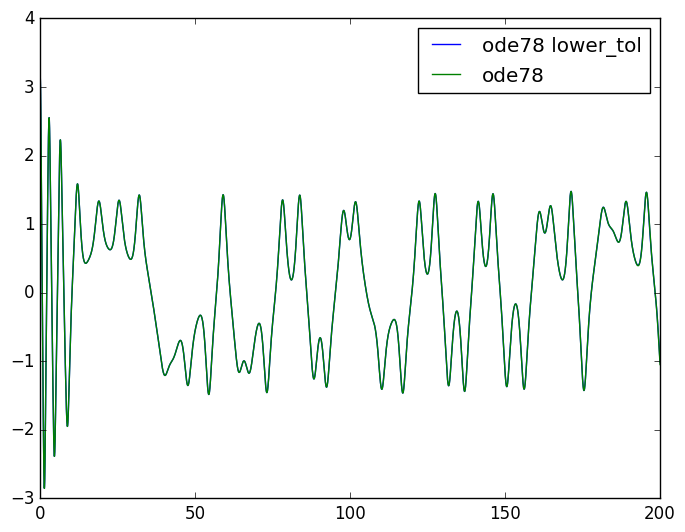

In [9]:
PyPlot.plot(t1, position1, label="ode78 lower_tol");
PyPlot.plot(t2, position2, label="ode78");
PyPlot.legend();

<b>Comparison between ode23s with different tolerances</b>

The results of ode23s solver do not converge.

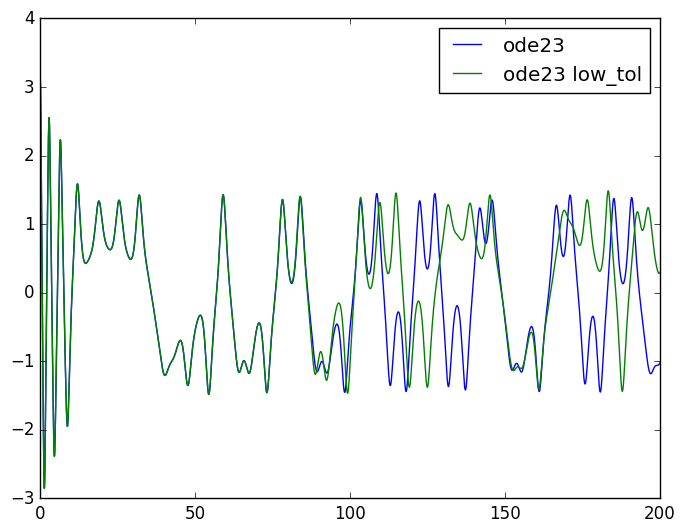

In [10]:
PyPlot.plot(t3, position3, label="ode23");
PyPlot.plot(t4, position4, label="ode23 low_tol");
PyPlot.legend();

<b>Differences analysis</b> (Assume ode78 solver with lower tolerance has the best result, since the results of ode78 converge, and it has the lowest tolerance.)

The y-axis is in log scale, the lower the y vaules are the better the results are.

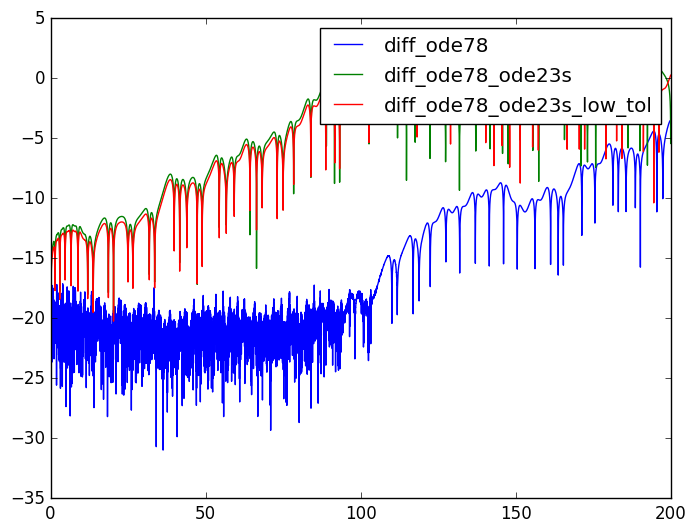

In [11]:
diff_ode78 = log(abs(position1 - position2));
diff_ode78_ode23s = log(abs(position1 - position3));
diff_ode78_ode23s_low_tol = log(abs(position1 - position4));

PyPlot.plot(t1, diff_ode78, label="diff_ode78");
PyPlot.plot(t1, diff_ode78_ode23s, label="diff_ode78_ode23s");
PyPlot.plot(t1, diff_ode78_ode23s_low_tol, label="diff_ode78_ode23s_low_tol");
PyPlot.legend();